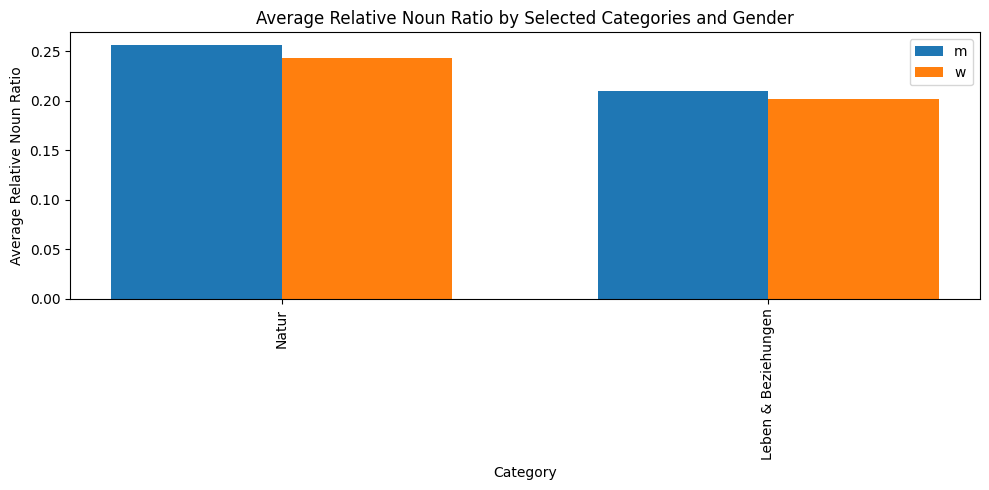

Gender: m
Overall average relative noun ratio: 0.23078193983039774
Median relative noun ratio: 0.22140522875816993
Minimum relative noun ratio: 0.0136986301369863
Maximum relative noun ratio: 0.38636363636363635 

Gender: w
Overall average relative noun ratio: 0.21636400083868598
Median relative noun ratio: 0.21818181818181817
Minimum relative noun ratio: 0.03333333333333333
Maximum relative noun ratio: 0.5085616438356164 

Gender: m
Category: Natur
10 most common nouns: [('Wolken', 20), ('Erde', 18), ('Zeit', 18), ('Licht', 14), ('Gras', 13), ('Wasser', 12), ('Leben', 12), ('Meer', 12), ('Augen', 11), ('Wald', 10)] 

Category: Leben & Beziehungen
10 most common nouns: [('Zeit', 17), ('Frau', 14), ('Liebe', 13), ('Nacht', 12), ('Leben', 11), ('Loop', 11), ('Wegen', 11), ('Glück', 9), ('Augen', 9), ('Gras', 8)] 

Gender: w
Category: Natur
10 most common nouns: [('Mission', 125), ('Wasser', 11), ('Fluss', 11), ('Rücken', 9), ('Wind', 9), ('Schnee', 9), ('Flüsse', 9), ('tag', 8), ('Zeit',

In [1]:
import os
import json
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import statistics

from scipy.stats import ttest_ind, shapiro, mannwhitneyu

path = r'corpus_finished'

# Load German tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('de_core_news_md')

# Function to extract nouns from a text
def extract_nouns(text):
    doc = nlp(text)
    return [token.text for token in doc if token.pos_ == 'NOUN']

# Initialize data structures
nouns_gender_category = {'m': {}, 'w': {}}
noun_ratios_gender_category = {'m': {}, 'w': {}}

# Iterate over .json files
for filename in os.listdir(path):
    if filename.endswith('.json'):
        with open(os.path.join(path, filename), 'r', encoding='utf-8') as f:
            data = json.load(f)
            gender = data['gender']
            poem_text = ' '.join(line['text'] for line in data['poem'].values())
            nouns = extract_nouns(poem_text)
            ratio = len(nouns) / len(poem_text.split())
            for category in data['categories']:
                if category not in nouns_gender_category[gender]:
                    nouns_gender_category[gender][category] = Counter()
                    noun_ratios_gender_category[gender][category] = []
                nouns_gender_category[gender][category].update(nouns)
                noun_ratios_gender_category[gender][category].append(ratio)

# Calculate average noun ratios for each gender and category
average_ratios_gender_category = {
    gender: {category: sum(ratios) / len(ratios) for category, ratios in categories.items()}
    for gender, categories in noun_ratios_gender_category.items()
}

# Select categories
selected_categories = ['Natur', 'Leben & Beziehungen']

# Get all unique genders
all_genders = sorted(list(average_ratios_gender_category.keys()))

# Create a bar chart for each category, comparing genders
bar_width = 0.35
index = np.arange(len(selected_categories))

plt.figure(figsize=(10, 5))

for i, gender in enumerate(all_genders):
    ratios = [average_ratios_gender_category[gender].get(category, 0) for category in selected_categories]
    plt.bar(index + i * bar_width, ratios, bar_width, label=gender)

plt.title('Average Relative Noun Ratio by Selected Categories and Gender')
plt.xlabel('Category')
plt.ylabel('Average Relative Noun Ratio')
plt.xticks(index + bar_width / 2, selected_categories, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Print the overall, median, minimum and maximum noun ratio for each gender
for gender in all_genders:
    all_ratios = [ratio for ratios in noun_ratios_gender_category[gender].values() for ratio in ratios]
    print(f'Gender: {gender}')
    print('Overall average relative noun ratio:', sum(all_ratios) / len(all_ratios))
    print('Median relative noun ratio:', statistics.median(all_ratios))
    print('Minimum relative noun ratio:', min(all_ratios))
    print('Maximum relative noun ratio:', max(all_ratios), '\n')

# Print the 10 most common nouns for each gender and selected category
for gender in all_genders:
    print(f'Gender: {gender}')
    for category in selected_categories:
        print(f'Category: {category}')
        print('10 most common nouns:', nouns_gender_category[gender][category].most_common(10), '\n')

# Print the 10 most common nouns for each gender overall
for gender in all_genders:
    all_nouns = Counter()
    for counter in nouns_gender_category[gender].values():
        all_nouns.update(counter)
    print(f'Gender: {gender}')
    print('10 most common nouns overall:', all_nouns.most_common(10), '\n')


In [4]:
# Funktion zum Durchführen des Shapiro-Wilk-Tests und zur Interpretation der Ergebnisse
def test_normality(data, sample_name):
    stat, p_value = shapiro(data)
    alpha = 0.05  # Signifikanzniveau
    print(f"Shapiro-Wilk-Test für {sample_name}:")
    print("Teststatistik:", stat)
    print("p-Wert:", p_value)
    if p_value > alpha:
        print(f"Die Substantivfrequenzen für {sample_name} sind normalverteilt.")
    else:
        print(f"Die Substantivfrequenzen für {sample_name} sind nicht normalverteilt.")

# Durchführung des Tests für beide Subsamples
ratios_m = [ratio for ratios in noun_ratios_gender_category['m'].values() for ratio in ratios]
ratios_w = [ratio for ratios in noun_ratios_gender_category['w'].values() for ratio in ratios]
test_normality(ratios_m, "Sample M")
test_normality(ratios_w, "Sample W")

Shapiro-Wilk-Test für Sample M:
Teststatistik: 0.9746562242507935
p-Wert: 1.2805265896531637e-06
Die Substantivfrequenzen für Sample M sind nicht normalverteilt.
Shapiro-Wilk-Test für Sample W:
Teststatistik: 0.9501235485076904
p-Wert: 1.0152957585773947e-08
Die Substantivfrequenzen für Sample W sind nicht normalverteilt.


In [ ]:
import scipy.stats as stats

# Perform a t-test to compare the means of the two groups
t_stat, p_val = stats.ttest_ind(ratios_m, ratios_w)

print('T-statistic:', t_stat)
print('p-value:', p_val)

T-statistic: 2.54702849189435
p-value: 0.011071390577351608


In [ ]:
# Perform the Mann-Whitney-U-Test to compare the distributions
u_stat, p_val = stats.mannwhitneyu(ratios_m, ratios_w, alternative='two-sided')

print('Mann-Whitney U-Statistik:', u_stat)
print('p-Wert:', p_val)

Mann-Whitney U-Statistik: 72304.0
p-Wert: 0.0020431322695246127
